# Federated Learning Approach for Estimating Head Load Capacity of District Heating Substations using LSTM

**Methods:**
1. Installation of tensorflow, tensorflow_federated and necessary libraries if required
2. Import libraries
3. Data Preparation
4. Sequential Keras model - LSTM (defination, architecture and parameters)
5. TFF Model Wrapper
6. Federated Training - (Collecting metrics, local, global model evaluation)
7. Visualization
8. Statistical Analysis
9. Main Federated loop - entry point of execution


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install tensorflow_federated

In [2]:
pip show tensorflow-federated

Name: tensorflow_federated
Version: 0.87.0
Summary: An open-source framework for machine learning and other computations on decentralized data.
Home-page: 
Author: 
Author-email: TensorFlow Federated Team <no-reply@google.com>
License: 
                              Apache License
                        Version 2.0, January 2004
                     http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1. Definitions.

   "License" shall mean the terms and conditions for use, reproduction,
   and distribution as defined by Sections 1 through 9 of this document.

   "Licensor" shall mean the copyright owner or entity authorized by
   the copyright owner that is granting the License.

   "Legal Entity" shall mean the union of the acting entity and all
   other entities that control, are controlled by, or are under common
   control with that entity. For the purposes of this definition,
   "control" means (i) the power, direct or indirect, to caus

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

In [5]:
# 1. Import libraries
import os
import glob
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [6]:
# 2. ---------------------- Config ----------------------

SEQ_LENGTH = 24
BATCH_SIZE = 24
WEEK_HOURS = 168
DATA_DIR = "/content/drive/MyDrive/thesis_timeseries/data"  # Path to .pkl files
EPOCHS = 3
ONE_YEAR_HOURS = 8760  # 365 * 24
# test_data = 2190

In [7]:
# 3. ---------------------- Data Preparation ----------------------
# --------------------------------------------------------------
def load_and_preprocess_data(file_path):
    '''
    1. Data Loading and Preprocessing
    2. Data Splitting and Scaling
    3. Splitting into train and validation data
    4. Sequence Creation and Weekly Batching
    '''
    df = pd.read_pickle(file_path)

    if len(df) > ONE_YEAR_HOURS:
        df = df[-ONE_YEAR_HOURS:]

    df = df[['kwh', 'm3h']].astype(np.float32)

    # 80-20 Split for train and test
    split = int(0.8 * len(df))
    train_df, test_df = df[:split], df[split:]

    # Apply MinMax scaling
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df)
    test_scaled = scaler.transform(test_df)

    # split training into train and validation (80% train, 20% val)
    val_split = int(0.8 * len(train_scaled))
    local_train = train_scaled[:val_split]
    local_val = train_scaled[val_split:]

    return local_train, local_val, test_scaled

# ---------------- Sequence Creation -------------------------
def create_sequences(data, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# ---------------- Weekly Batching---------------------------

def split_weekly_sequences(X, y, week_hours=WEEK_HOURS):
    week_batches = []
    samples_per_week = week_hours - SEQ_LENGTH
    for i in range(0, len(X), samples_per_week):
        X_batch = X[i:i + samples_per_week]
        y_batch = y[i:i + samples_per_week]
        if len(X_batch) == samples_per_week:
            dataset = tf.data.Dataset.from_tensor_slices((X_batch, y_batch)).batch(BATCH_SIZE)
            week_batches.append(dataset)
    return week_batches

In [8]:
# 4. ---------------------- LSTM Model ----------------------
# --------------------------------------------------------
def build_stacked_lstm_model():
    # Add early stopping -- to be
    '''
    Keras Model Definition
    A stacked LSTM with 64 and 32 hidden units, followed by a Dense layer for final prediction.
    Use of Dropout for regularization.
    L2 regularization to the LSTM layers for better generalization - Helps with weight decay.
    L2 Regularization: Adds a penalty to the loss function for large weights, improving generalization.
    A Learning Rate Scheduler for adaptive learning during rounds - Adaptive learning rates based on the epoch.
    '''
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(SEQ_LENGTH, 2)),
        tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])


    # Learning Rate Scheduler: Gradually reduces the learning rate as training progresses, helping with convergence.
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=1000,
        decay_rate=0.9
    )

    return model

In [9]:
# ---------------------- Comparison ----------------------
# -----------------------------------------------------------------

def compare_local_vs_global(global_weights, clients_weekly_data, round_num):
    local_mae, local_loss = [], []

    print(f"\nComparison between Local and Global model on Training at Round {round_num + 1}")
    for client_idx, client_data in enumerate(clients_weekly_data):
        local_model = build_stacked_lstm_model()
        local_model.set_weights(global_weights)
        local_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        loss, mae = local_model.evaluate(client_data[round_num], verbose=0)
        print(f"Client {client_idx + 1} - Local MAE: {mae:.4f}, Local Loss: {loss:.4f}")
        local_mae.append(mae)
        local_loss.append(loss)

    global_mae = np.mean(local_mae)
    global_loss = np.mean(local_loss)
    print(f"Global MAE: {global_mae:.4f}, Global Loss: {global_loss:.4f}")

    return local_mae, local_loss


def compare_local_vs_global(global_weights, clients_weekly_data, round_num):
    local_mae = []
    local_loss = []

    print(f"\nComparison between Local and Global model on Training data at Round {round_num + 1}")
    for client_idx, client_data in enumerate(clients_weekly_data):
        local_model = build_stacked_lstm_model()
        local_model.set_weights(global_weights)
        local_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        loss, mae = local_model.evaluate(client_data[round_num], verbose=0)
        print(f"Client {client_idx + 1} - Local MAE: {mae:.4f}, Local Loss: {loss:.4f}")

        local_mae.append(mae)
        local_loss.append(loss)

    global_mae = np.mean(local_mae)
    global_loss = np.mean(local_loss)


    print(f"Global MAE (Averaged): {global_mae:.4f}, Global Loss (Averaged): {global_loss:.4f}")
    return local_mae, local_loss


    # ---------------------- Test Evaluation per Round ----------------------
def evaluate_on_test_data_per_round(global_weights, federated_test_data, round_num):
    test_mae, test_loss = [], []

    global_model = build_stacked_lstm_model()
    global_model.set_weights(global_weights)
    global_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(f"\n--- Global Evaluation on Test Data at Round {round_num + 1} ---")
    for idx, test_data in enumerate(federated_test_data):
        loss, mae = global_model.evaluate(test_data, verbose=0)
        print(f"Client {idx + 1} - Test MAE: {mae:.4f}, Test Loss: {loss:.4f}")
        test_mae.append(mae)
        test_loss.append(loss)

    return test_mae, test_loss

In [10]:
# 5. ---------------------- TFF Model Wrapper ----------------------
# ---------------------------------------------------------------

def model_fn():
    '''
    TensorFlow Federated (TFF) Model Wrapper
    6. Wrap the Keras model with TensorFlow Federated
    TFF does the following:
      Takes Keras model architecture (keras_model).
      Wraps it in a Federated Learning shell to be compatible with distributed training.
      Builds a model with:
        forward_pass: Local training on each client.
        report_local_outputs: Collects metrics locally.
        federated_aggregate: Combines the updates globally.
    '''

    keras_model = build_stacked_lstm_model()
    # Input specification for TFF should match the data format
    input_spec = (tf.TensorSpec(shape=(None, SEQ_LENGTH, 2), dtype=tf.float32),
                  tf.TensorSpec(shape=(None,), dtype=tf.float32))

    # Wrapping Keras model into a TFF model
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0)
    #client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    #server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [11]:
# 6. ---------------------- Federated Training ----------------------
# ----------------------------------------------------------------

def federated_train(iterative_process, state, clients_weekly_data, clients_val_data, federated_test_data, num_weeks):
    """
    Federated Training Loop with:
    - Local vs Global Comparison
    - Validation Metrics
    - Test Evaluation per round
    """
    print(f"Starting Federated Training for {num_weeks} Rounds...\n")

    # Initialize Metrics
    num_clients = len(clients_weekly_data)
    history = {
        'global_train_mae': [],
        'global_train_loss': [],
        'global_test_mae': [],
        'global_test_loss': [],
        'global_val_mae': [],
        'global_val_loss': [],
        'local_mae': [[] for _ in range(num_clients)],
        'local_loss': [[] for _ in range(num_clients)],
        'local_val_mae': [[] for _ in range(num_clients)],
        'local_val_loss': [[] for _ in range(num_clients)],
        'local_test_mae': [[] for _ in range(num_clients)],
        'local_test_loss': [[] for _ in range(num_clients)]
    }

    for round_num in range(num_weeks):
        print(f"\n------------- Federated Round {round_num + 1}/{num_weeks} --------------")

        # Get current week's data for all clients, safely
        current_week_data = []
        for client_idx in range(len(clients_weekly_data)):
            if round_num < len(clients_weekly_data[client_idx]):
                current_week_data.append(clients_weekly_data[client_idx][round_num])
            else:
                print(f"Warning: Client {client_idx + 1} has no data for week {round_num + 1}. Skipping...")

        if not current_week_data:
            print(f"Skipping Round {round_num + 1} due to missing client data.")
            continue

        # Perform Federated Training
        state, metrics = iterative_process.next(state, current_week_data)
        print(f"Training Metrics: {metrics}")
        global_weights = iterative_process.get_model_weights(state).trainable

        # Collect Global Metrics
        global_mae = metrics['client_work']['train']['mean_absolute_error']
        global_loss = metrics['client_work']['train']['loss']
        history['global_train_mae'].append(global_mae)
        history['global_train_loss'].append(global_loss)

        # ---------------- Local vs Global Comparison ----------------
        local_mae, local_loss = compare_local_vs_global(global_weights, clients_weekly_data, round_num)

        for client_idx in range(num_clients):
            history['local_mae'][client_idx].append(local_mae[client_idx])
            history['local_loss'][client_idx].append(local_loss[client_idx])

        # ---------------- Validation Metrics ----------------
        val_mae, val_loss = [], []
        for client_idx, val_data in enumerate(clients_val_data):
            model = build_stacked_lstm_model()
            model.set_weights(global_weights)
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            loss, mae = model.evaluate(val_data, verbose=0)
            val_mae.append(mae)
            val_loss.append(loss)
            history['local_val_mae'][client_idx].append(mae)
            history['local_val_loss'][client_idx].append(loss)

        # Global mean val_mae and val_loss
        history['global_val_mae'].append(np.mean(val_mae))
        history['global_val_loss'].append(np.mean(val_loss))

        # ---------------- Test Metrics ----------------
        test_mae, test_loss = evaluate_on_test_data_per_round(global_weights, federated_test_data, round_num)
        for client_idx in range(num_clients):
            history['local_test_mae'][client_idx].append(test_mae[client_idx])
            history['local_test_loss'][client_idx].append(test_loss[client_idx])

        history['global_test_mae'].append(np.mean(test_mae))
        history['global_test_loss'].append(np.mean(test_loss))

    print("\nFederated Training Completed................!")
    return state, history


In [12]:
# ------------------ Local Evaluation ----------------------
# ----------------------------------------------------------

def local_evaluate(global_weights, clients_weekly_data, round_num=0):
    """
    Local evaluation happens after global weights are set back to local models.
    This is for understanding how each local client performs after aggregation.
    Evaluates on the weekly local batches.
    """
    local_mae_per_round = []
    local_loss_per_round = []

    for client_idx, client_data in enumerate(clients_weekly_data):
        local_model = build_stacked_lstm_model()
        local_model.set_weights(global_weights)
        local_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Safely check if the round number is valid for the client
        if round_num < len(client_data):
            #print(f"Evaluating Client {client_idx + 1} for Round {round_num + 1}")
            try:
                loss, mae = local_model.evaluate(client_data[round_num], verbose=0)
                local_loss_per_round.append(loss)
                local_mae_per_round.append(mae)
            except Exception as e:
                print(f"Issue during evaluation for Client {client_idx + 1}: {e}")
        else:
            print(f"Warning: Client {client_idx + 1} has no data for round {round_num + 1}. Skipping...")

    # Return lists even if empty for safe unpacking
    return local_mae_per_round, local_loss_per_round

In [13]:
# ---------------- Global Evaluation-------------------
# --------------------------------------------------------

def global_evaluate(global_weights, federated_test_data, federated_val_data=None):
    """
    Evaluates the global model after all federated rounds are done.
    Supports both test data and optional validation data.
    """
    keras_model = build_stacked_lstm_model()
    keras_model.set_weights(global_weights)
    keras_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("\nEvaluation on each client's test data:")
    test_mae, test_loss = [], []

    for i, test_dataset in enumerate(federated_test_data):
        print(f"Evaluating Test Data for Client {i + 1}")
        try:
            loss, mae = keras_model.evaluate(test_dataset, verbose=0)
            print(f"Client {i + 1}: Test Loss = {loss:.4f}, Test MAE = {mae:.4f}")
            test_mae.append(mae)
            test_loss.append(loss)
        except Exception as e:
            print(f"Issue during test evaluation for Client {i + 1}: {e}")

    if federated_val_data:
        print("\nOptional Evaluation on Validation Data:")
        for i, val_dataset in enumerate(federated_val_data):
            print(f"Evaluating Validation Data for Client {i + 1}")
            try:
                loss, mae = keras_model.evaluate(val_dataset, verbose=0)
                print(f"Client {i + 1}: Validation Loss = {loss:.4f}, Validation MAE = {mae:.4f}")
            except Exception as e:
                print(f"Issue during validation evaluation for Client {i + 1}: {e}")

    # Optional: Return metrics if you want to log them
    return test_mae, test_loss

In [14]:
# 6. ---------------------- Visualization ----------------------
# ----------------------------------------------------------------

def plot_local_vs_global(history):
    """
    Visualizes Local vs Global MAE and Loss for Training, Validation, and Test.
    Args:
    - history (dict): Contains global and local MAE/Loss for training, validation, and test.
    """
    rounds = len(history['global_train_mae'])

    # --- Plot Training MAE ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_train_mae'], label='Global Training MAE', linewidth=2, color='black')
    for client_idx, mae_list in enumerate(history['local_mae']):
        plt.plot(mae_list, linestyle='--', label=f'Client {client_idx + 1} Local MAE')
    plt.title('Training MAE: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_mae_local_vs_global.png')
    plt.show()


    # --- Plot Training Loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_train_loss'], label='Global Training Loss', linewidth=2, color='black')
    for client_idx, loss_list in enumerate(history['local_loss']):
        plt.plot(loss_list, linestyle='--', label=f'Client {client_idx + 1} Local Loss')
    plt.title('Training Loss: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_loss_local_vs_global.png')
    plt.show()

    # --- Plot Validation MAE ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_val_mae'], label='Global Validation MAE', linestyle='-', linewidth=2, color='orange')
    for client_idx, mae_list in enumerate(history['local_val_mae']):
        plt.plot(mae_list, linestyle='--', label=f'Client {client_idx + 1} Local Val MAE')
    plt.title('Validation MAE: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('validation_mae_local_vs_global.png')
    plt.show()

    # --- Plot Validation Loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_val_loss'], label='Global Validation Loss', linestyle='-', linewidth=2, color='red')
    for client_idx, loss_list in enumerate(history['local_val_loss']):
        plt.plot(loss_list, linestyle='--', label=f'Client {client_idx + 1} Local Val Loss')
    plt.title('Validation Loss: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('validation_loss_local_vs_global.png')
    plt.show()

    # --- Plot Test MAE ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_test_mae'], label='Global Test MAE', linewidth=2, color='blue')
    for client_idx, mae_list in enumerate(history['local_test_mae']):
        plt.plot(mae_list, linestyle='--', label=f'Client {client_idx + 1} Local Test MAE')
    plt.title('Test MAE: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('test_mae_local_vs_global.png')
    plt.show()

    # --- Plot Test Loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['global_test_loss'], label='Global Test Loss', linewidth=2, color='green')
    for client_idx, loss_list in enumerate(history['local_test_loss']):
        plt.plot(loss_list, linestyle='--', label=f'Client {client_idx + 1} Local Test Loss')
    plt.title('Test Loss: Local vs Global')
    plt.xlabel('Federated Round')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('test_loss_local_vs_global.png')
    plt.show()


In [15]:
# 7. --------- Statistical Analysis ------------

def statistical_analysis(global_mae, local_mae_list):
    """
    Perform paired t-tests for statistical significance between global MAE and each client's local MAE.
    """
    print("--- Statistical Analysis (Paired T-Test) ---")
    for i, local_mae in enumerate(local_mae_list):
        if len(global_mae) != len(local_mae):
            print(f"Client {i + 1}: Length mismatch, skipping statistical analysis.")
            continue

        t_stat, p_value = ttest_rel(global_mae, local_mae)
        print(f"Client {i + 1}: T-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

        if p_value < 0.05:
            print(f"Statistically significant difference for Client {i + 1}")
        else:
            print(f"No significant difference for Client {i + 1}")


def plot_standard_deviation(local_mae_list, local_loss_list):
    """
    Plot the standard deviation of MAE and Loss for each client.
    """
    plt.figure(figsize=(10, 5))
    std_dev_mae = [np.std(mae) for mae in local_mae_list]
    std_dev_loss = [np.std(loss) for loss in local_loss_list]

    bar_width = 0.35
    indices = np.arange(len(std_dev_mae))

    plt.bar(indices, std_dev_mae, bar_width, color='skyblue', label='MAE Std Dev')
    plt.bar(indices + bar_width, std_dev_loss, bar_width, color='lightcoral', label='Loss Std Dev')

    plt.title('Standard Deviation of Local Models')
    plt.xlabel('Client Index')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(indices + bar_width / 2, [f'Client {i+1}' for i in range(len(std_dev_mae))])
    plt.savefig('local_model_std_dev.png')
    plt.show()


def plot_convergence(global_mae, local_mae_list):
    """
    Plot the convergence of global vs. local models across rounds.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(global_mae, label='Global MAE', color='black', linewidth=2)

    for idx, local_mae in enumerate(local_mae_list):
        plt.plot(local_mae, linestyle='--', label=f'Client {idx + 1} Local MAE')

    plt.title('Model Convergence Over Rounds')
    plt.xlabel('Federated Round')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('model_convergence.png')
    plt.show()


def plot_residuals(global_mae, local_mae_list):
    """
    Plot the residuals (Local MAE - Global MAE) over rounds for each client.
    """
    plt.figure(figsize=(10, 5))
    for idx, local_mae in enumerate(local_mae_list):
        if len(local_mae) == len(global_mae):
            residuals = np.array(local_mae) - np.array(global_mae)
            plt.plot(residuals, linestyle='--', label=f'Client {idx + 1} Residuals')
        else:
            print(f"Client {idx + 1}: Length mismatch, skipping residual plot.")

    plt.title('Residual Analysis of Local vs Global Model')
    plt.xlabel('Federated Round')
    plt.ylabel('Residual (Local - Global)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('model_residuals.png')
    plt.show()


Loading and processing data for /content/drive/MyDrive/thesis_timeseries/data/695645.pkl
Loading and processing data for /content/drive/MyDrive/thesis_timeseries/data/695947.pkl
Loading and processing data for /content/drive/MyDrive/thesis_timeseries/data/696204.pkl
Data loaded successfully for all clients.....
Federated learning process initialized................!
Starting Federated Training for 38 Rounds...


------------- Federated Round 1/38 --------------
Training Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.13277854), ('loss', 0.02262554), ('num_examples', 432), ('num_batches', 18)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

Comparison between Local and Global model on Training data at Round 1
Client 1 - Local MAE: 0.1264, Local Loss: 0.1281
Client 2 - Local MAE: 0.0601, Local Loss: 0.1151
Client 3 - Local MAE: 0

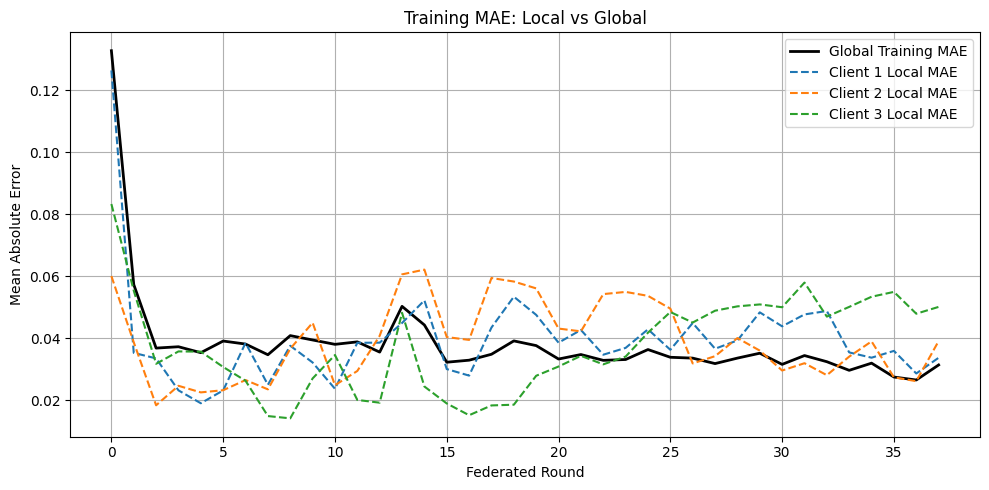

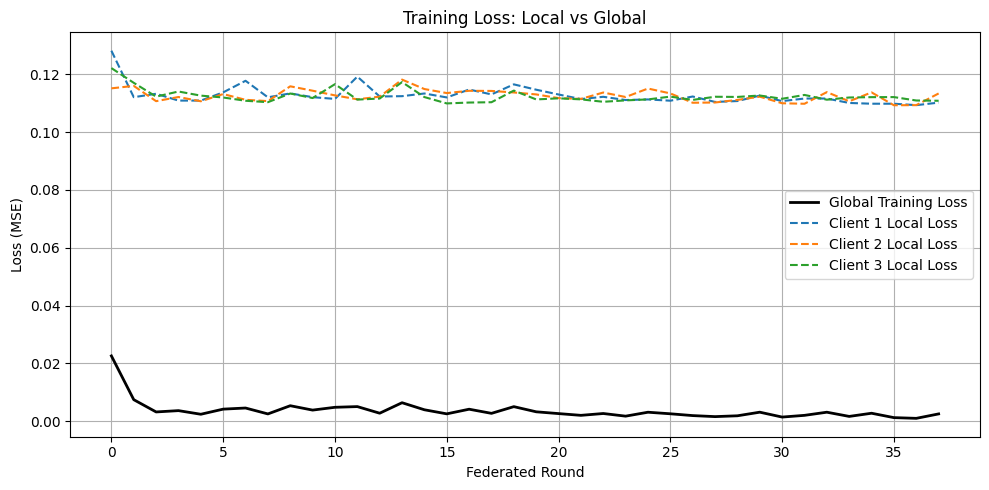

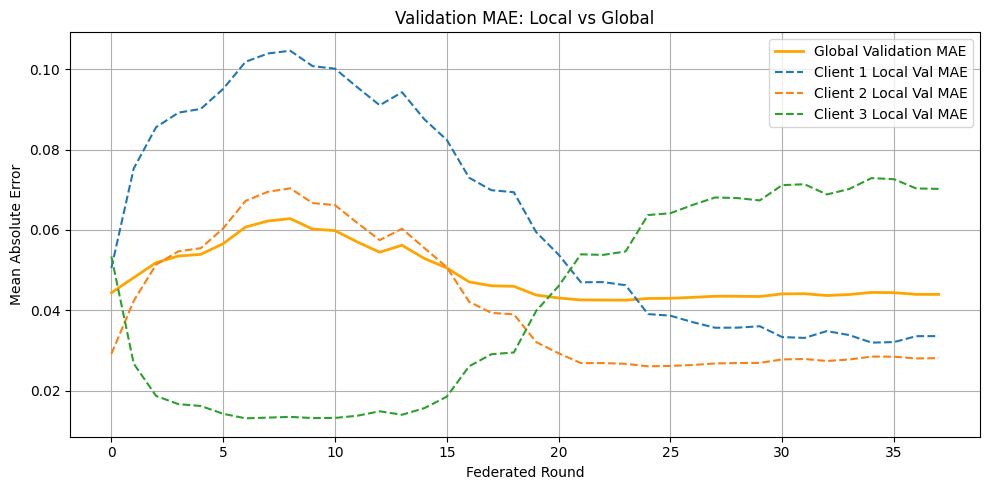

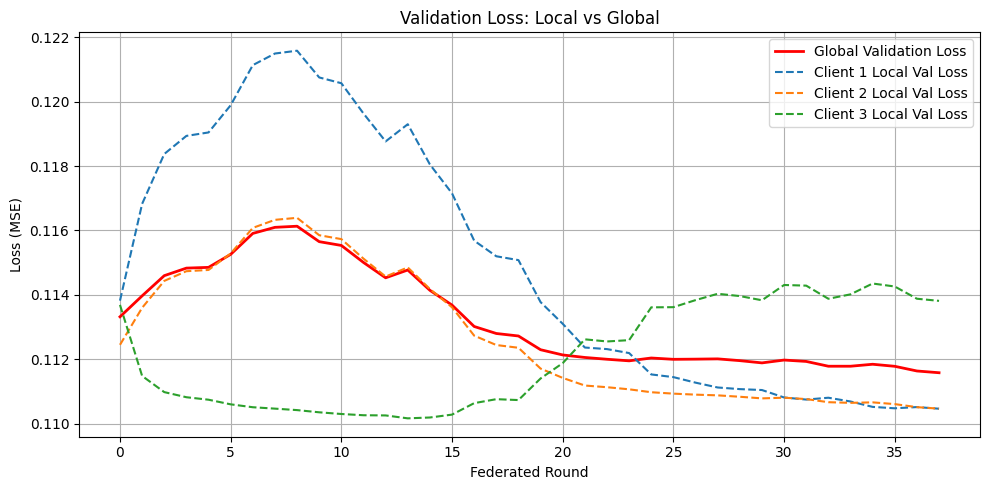

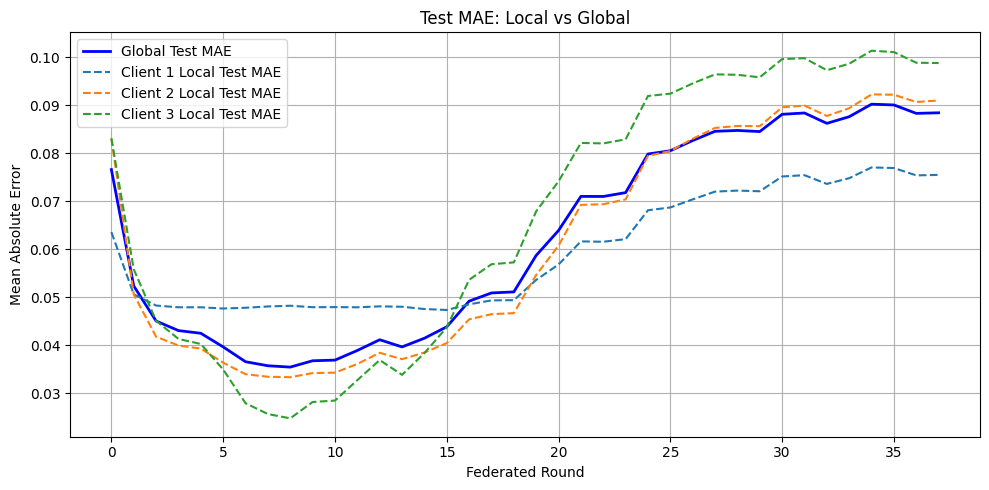

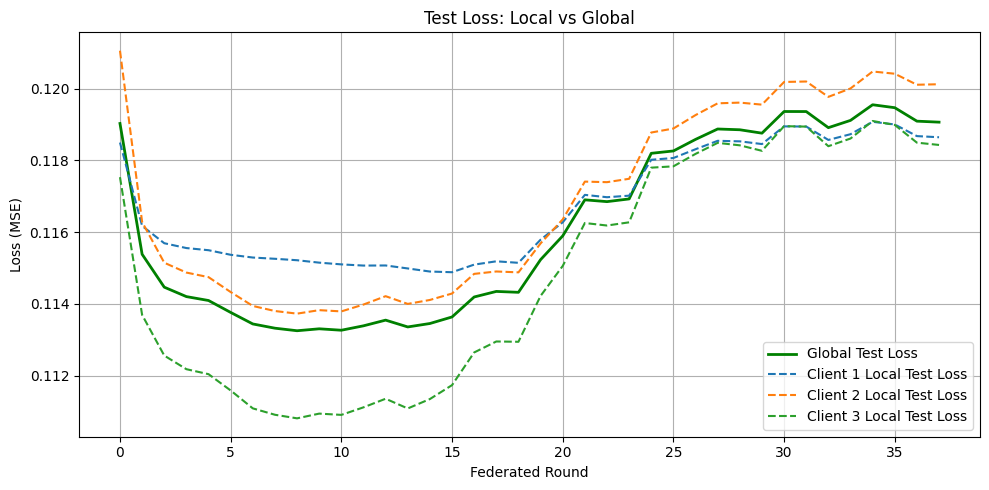

--- Statistical Analysis (Paired T-Test) ---
Client 1: T-statistic = -0.7507, p-value = 0.4576
No significant difference for Client 1
Client 2: T-statistic = -0.2526, p-value = 0.8020
No significant difference for Client 2
Client 3: T-statistic = 0.2940, p-value = 0.7704
No significant difference for Client 3


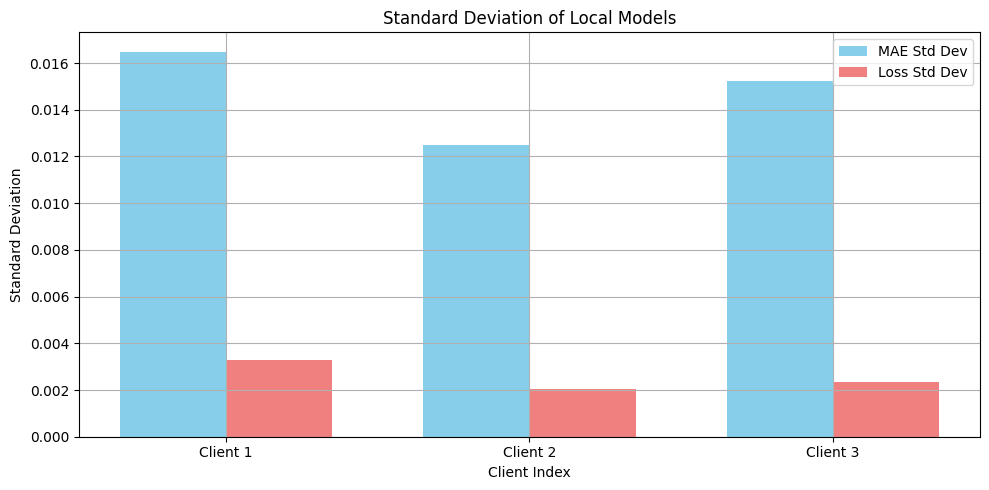

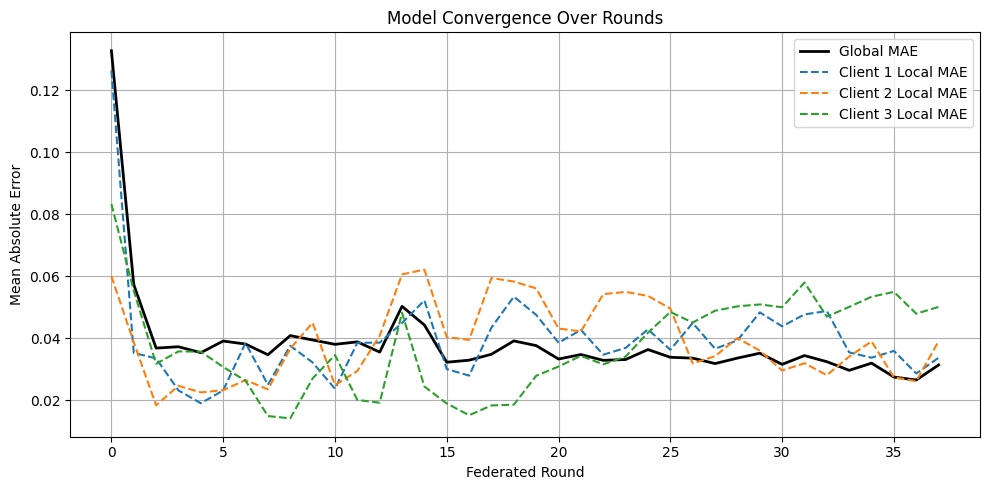

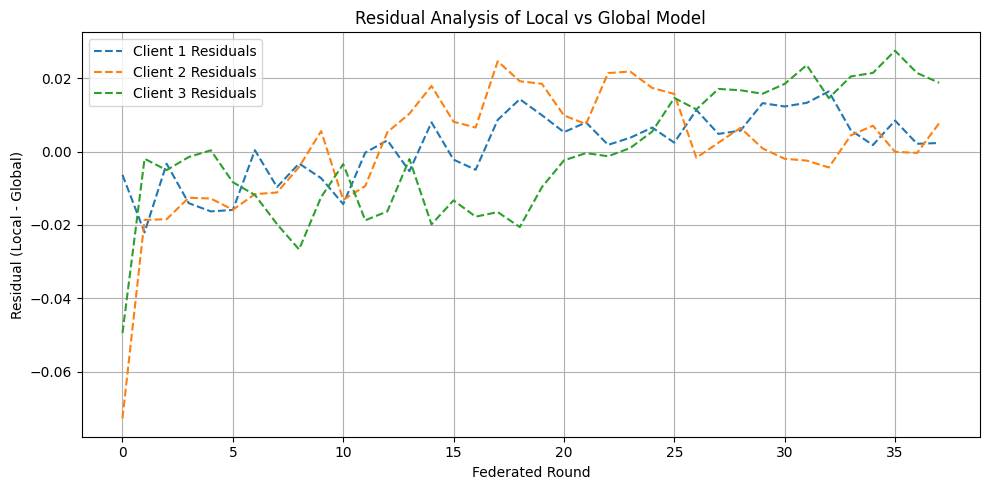

In [16]:
# 8. ---------------------- Main Federated Loop ----------------------
# ----------------------------------------------------------------

if __name__ == '__main__':
    # Load Data
    client_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pkl")))
    clients_weekly_data = []
    clients_val_data = []
    federated_test_data = []

    for file in client_files:
        print(f"Loading and processing data for {file}")
        train_scaled, val_scaled, test_scaled = load_and_preprocess_data(file)

        # Create sequences
        X_train, y_train = create_sequences(train_scaled)
        X_val, y_val = create_sequences(val_scaled)
        X_test, y_test = create_sequences(test_scaled)

        # Weekly batches for training
        weekly_batches = split_weekly_sequences(X_train, y_train)
        clients_weekly_data.append(weekly_batches)

        # Validation and Test datasets (batched)
        clients_val_data.append(tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE))
        federated_test_data.append(tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE))

    # Ensure data is properly loaded
    if not clients_weekly_data or not clients_weekly_data[0]:
        raise ValueError("Client data is empty. Check the data loading process.")

    print("Data loaded successfully for all clients.....")

    # ---------------------- Initialize the Federated Model ----------------------
    state = iterative_process.initialize()
    num_weeks = min(len(weekly_batches) for weekly_batches in clients_weekly_data)

    # ---------------------- Federated Training with Validation and Test ----------------------

    # Initialize the federated model (to be called in main loop)
    print("Federated learning process initialized................!")

    state, history = federated_train(
        iterative_process, state, clients_weekly_data, clients_val_data, federated_test_data, num_weeks)

    # Get the final global weights
    global_weights = iterative_process.get_model_weights(state).trainable

    # ---------------------- Final Local Evaluation ----------------------
    final_round_num = min(len(weeks) for weeks in clients_weekly_data) - 1
    print(f"\n--- Final Local Evaluation for {final_round_num + 1}---")
    for client_idx in range(len(clients_weekly_data)):
        #print(f"\nEvaluating on Local Client {client_idx + 1}:")
        local_mae, local_loss = local_evaluate(global_weights, clients_weekly_data, round_num=final_round_num)
        print(f"Client {client_idx + 1} - Final Local MAE: {local_mae[client_idx]:.4f}, Final Local Loss: {local_loss[client_idx]:.4f}")


    # ---------------------- Final Overall Global Evaluation on Test Data ----------------------
    print("\n--- Final Overall Global Evaluation on Test Data ---")
    global_evaluate(global_weights, federated_test_data)


    # ---------------------- Visualization ----------------------
    plot_local_vs_global(history)

    #----------------- Statistical Analysis ---------------------

    statistical_analysis(history['global_train_mae'], history['local_mae'])
    plot_standard_deviation(history['local_mae'], history['local_loss'])
    plot_convergence(history['global_train_mae'], history['local_mae'])
    plot_residuals(history['global_train_mae'], history['local_mae'])
